In [2]:
import numpy as np
from scipy.linalg import expm
import numpy.linalg as LA
import random

from qiskit import QuantumCircuit
from qiskit import Aer, transpile,execute
from qiskit.quantum_info import random_pauli, state_fidelity
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.visualization import plot_histogram, plot_state_city

def create_hamiltonian(Nq, cn, gamma, Bn):
    '''
    create Hamiltonian gate
    target Hamiltonian is H=1/2*cn((1+gamma)XX+(1-gamma)YY)+BnZn
    Nq -> number of qubit
    cn -> coupling constant
    gamma -> parameter
    Bn -> Magnetic field
    '''
    
    I_gate = [[1,0],[0,1]]
    X_gate = [[0,1],[1,0]]
    Y_gate = [[0,0-1j],[0+1j,0]]
    Z_gate = [[1,0],[0,-1]]

    
    XX= np.array(np.zeros(2**Nq))
    YY= np.array(np.zeros(2**Nq))
    Zn= np.array(np.zeros(2**Nq))
    for k in range(Nq-1):
        for l in range(Nq):
            if k==l:
                if l==0:
                    hamiX = X_gate
                    hamiY = Y_gate
                else:
                    hamiX = np.kron(hamiX,X_gate)
                    hamiY = np.kron(hamiY,Y_gate)
                
            elif k+1==l:
                hamiX = np.kron(hamiX,X_gate)
                hamiY = np.kron(hamiY,Y_gate)
            else:
                if l==0:
                    hamiX = I_gate
                    hamiY = I_gate
                else:
                    hamiX = np.kron(hamiX,I_gate)
                    hamiY = np.kron(hamiY,I_gate)
                    
        XX = XX+ 0.5*cn[k]*(1+gamma)*hamiX
        YY = YY+ 0.5*cn[k]*(1-gamma)*hamiY
        
    for m in range(Nq):
        for n in range(Nq):
            if m==n:
                if n==0:
                    hamiZ = Z_gate
                
                else:
                    hamiZ = np.kron(hamiZ,Z_gate)
            
            else:
                if n==0:
                    hamiZ = I_gate
                    
                else:
                    hamiZ = np.kron(hamiZ,I_gate)
        
        Zn = Zn + Bn[m]*hamiZ

    hamiltonian = XX + YY + Zn
    
    return hamiltonian

In [3]:
qubit = 5
cn = [1] * qubit #[1,1,1,1,1]
r = 0
bn = [0] * qubit #[0,0,0,0,0]

In [8]:
'''
計算の流れ（直接制御編）
1. 量子回路を準備
2. ハミルトニアンゲートを準備
3. 2のゲートの前後にrandom pauliを作用
4. (r-1)epsの確率でrandom pauliを作用させて、エラー率を制御
5. 1-4をnステップ繰り返す

計算の流れ（間接制御編）
間接制御の場合は、random pauliを先頭2bitに作用させる

直接制御と間接制御の場合で、時間発展させた時に得られる状態が一致するかどうか調査する
一致した場合は、error twirlingは間接制御でも有効に機能すると思われる

参考：https://arxiv.org/abs/1611.09301
'''

## 間接制御
qc = QuantumCircuit(qubit)
for i in range(1):
    t = 0.1
    ## Hamiltonianの時間発展を計算
    hami_gate = expm(-1j*create_hamiltonian(qubit,cn,r,bn)*t)
    hami_op = Operator(hami_gate)
    print(hami_op.input_dims())
    print(hami_op.output_dims())
    qc.append(hami_op,list(range(qubit)))
    
    ## 先頭2bitにrandom pauliゲートをかける
    ## TODO: qubitそれぞれに対して乱数を振る必要がある
    qc.append(random_pauli(2),[0,1])

    ## TODO
    '''
    1. random pauliをキャンセルするようなゲート操作を実施
    　　　　random pauliをUゲート、HamiltonianをAゲートとすると、AUA†でキャンセルする
        仮にAがControl-Zだった場合 (σ_c^c)(σ_t^d) = A(σ_c^a)(σ_t^b)A†
        ここで、cとdは以下で求める
        c = a + b(3-b)(3-2a)/2
        d = b + a(3-a)(3-2b)/2
        これでキャンセルするのなんでだっけ？
        AゲートがHamiltonianゲートの場合、cとdはどう求められる？
    2. (r-1)epsの確率でrandom pauliをかけて、エラー率を制御
    　　　　epsをどう求めるか？要確認
        - 全ての量子ビットに対してランダムパウリが同じ確率でかかっていると仮定している
    
    次のPauliがかかるまでの間で、全体にこのエラーが伝搬するくらい進んでいれば、間接/直接共に同じような結果が得られるのでは？
    
    - 色んな初期状態がどの状態（密度行列）に変化するのかを調べる（ある程度収束するまで計算する）
    - どれだけ少ない状態でできる？
      - （純粋状態ではなく）密度行列の基底数分(次元の二乗個の初期状態)あれば良い
      - プロセスともグラフィーの初期状態(X/Z基底) (|0><0| + |+><+|) ...
      - 2つの通信路の距離を最小化するパラメータを求めたい
      　　- diamond normを少ない次元で計算する方法ある？
        - 出てきた密度行列のmaxの距離を比較
    - 10qubitの最大エンタングル状態を作る
       - diamond norm
       - https://qiskit.org/documentation/stubs/qiskit.quantum_info.diamond_norm.html
       - https://qiskit.org/documentation/stable/0.26/locale/ja_JP/tutorials/noise/8_tomography.html
    '''

(2, 2, 2, 2, 2)
(2, 2, 2, 2, 2)


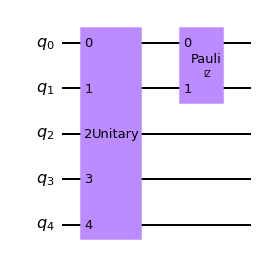

In [5]:
qc.draw('mpl')

In [7]:
backend = Aer.get_backend('unitary_simulator')
results = execute(qc, backend=backend).result()
unitary_mat =results.get_unitary(qc)
print(np.round(unitary_mat,4))

[[0.   +0.j     0.995+0.j     0.   -0.0997j ... 0.   +0.j
  0.   +0.j     0.   +0.j    ]
 [1.   +0.j     0.   +0.j     0.   +0.j     ... 0.   +0.j
  0.   +0.j     0.   +0.j    ]
 [0.   +0.j     0.   +0.j     0.   +0.j     ... 0.   +0.j
  0.   +0.j     0.   +0.j    ]
 ...
 [0.   +0.j     0.   +0.j     0.   +0.j     ... 0.   +0.j
  0.   +0.j     0.   +0.j    ]
 [0.   +0.j     0.   +0.j     0.   +0.j     ... 0.   +0.j
  0.   +0.j     1.   +0.j    ]
 [0.   +0.j     0.   +0.j     0.   +0.j     ... 0.   -0.0997j
  0.995+0.j     0.   +0.j    ]]


{'00100': 22, '01110': 5, '11010': 9, '01011': 8, '11100': 3, '10011': 339, '01101': 23, '11111': 2, '10110': 13, '11001': 32, '00111': 194, '00001': 276, '00010': 98}


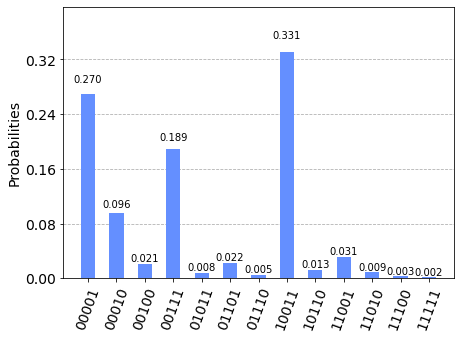

In [123]:
# Create a Quantum Circuit
meas = QuantumCircuit(qubit, qubit)
meas.barrier(range(qubit))
# map the quantum measurement to the classical bits
meas.measure(range(qubit), range(qubit))
circ = meas.compose(qc, front=True)

## Noisy quantum circuit simulator backend
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circ, backend), shots=1024)

# Grab the results from the job.
results_qasm = job.result()

counts = results_qasm.get_counts(circ)
print(counts)
plot_histogram(counts)


In [113]:
#drawing the circuit
circ.draw()

┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐»
q_0: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
     │          ││          ││          ││          ││          ││          │»
q_1: ┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├»
     │          ││          ││          ││          ││          ││          │»
q_2: ┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├»
     │          ││          ││          ││          ││          ││          │»
q_3: ┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├»
     │          ││          ││          ││          ││          ││          │»
q_4: ┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├»
     └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
c: 5/════════════════════════════════════════════════════════════════════════»
                                                                             »
«     ┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐»
«q_0: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_1: ┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_2: ┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├»
«     │          ││          ││          ││          ││          ││          │»
«q_3: ┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_4: ┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├»
«     └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐»
«q_0: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_1: ┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_2: ┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├»
«     │          ││          ││          ││          ││          ││          │»
«q_3: ┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_4: ┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├»
«     └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«     ┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐┌──────────┐»
«q_0: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_1: ┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├┤1         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_2: ┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├┤2 Unitary ├»
«     │          ││          ││          ││          ││          ││          │»
«q_3: ┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├┤3         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_4: ┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├┤4         ├»
«     └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
«c: 5/════════════

In [71]:
### TODO
'''
- 1qubit目に磁場を入れる
- randomユニタリではなくランダムPauliにする
- ランダムPauliは1,2qubits ver と全qubit verの２つとする
- 2つの状態が同じかどうか確認する
  - state_fidelity(desired_vector,qc_state)
'''

'\n- 1qubit目に磁場を入れる\n- randomユニタリではなくランダムPauliにする\n- ランダムPauliは1,2qubits ver と全qubit verの２つとする\n- 2つの状態が同じかどうか確認する\n  - state_fidelity(desired_vector,qc_state)\n'

In [117]:
## 直接制御
qc2 = QuantumCircuit(qubit)
for i in range(100):
#     qc2.append(random_pauli(qubit), list(range(qubit)))
    qc2.append(random_pauli(2),[0,1])
    t = 0.1
    ## Hamiltonianの時間発展を計算
    hami_gate = expm(-1j*create_hamiltonian(qubit,cn,r,bn)*t)
    hami_op = Operator(hami_gate)
    qc2.append(hami_op,list(range(qubit)))


{'00111': 1, '01011': 22, '11010': 8, '10110': 9, '11111': 3, '00001': 274, '00100': 201, '10000': 8, '01101': 2, '10011': 26, '00010': 272, '01110': 28, '01000': 170}


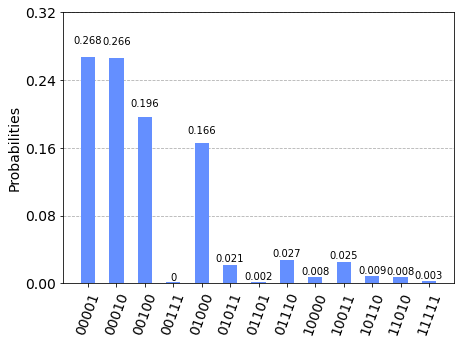

In [118]:
# Create a Quantum Circuit
meas2 = QuantumCircuit(qubit, qubit)
meas2.barrier(range(qubit))
# map the quantum measurement to the classical bits
meas2.measure(range(qubit), range(qubit))
circ2 = meas2.compose(qc2, front=True)

## Noisy quantum circuit simulator backend
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circ2, backend), shots=1024)

# Grab the results from the job.
results_qasm = job.result()

counts = results_qasm.get_counts(circ2)
print(counts)
plot_histogram(counts)

In [135]:
## 状態ベクトルのfidelityをチェック
backend = Aer.get_backend('statevector_simulator')
result = backend.run(qc).result()
print(result.get_statevector(qc))
result2 = backend.run(qc2).result()
print(result2.get_statevector(qc2))
state_fidelity(result.get_statevector(qc), result2.get_statevector(qc2))

[ 0.        +0.j          0.        -0.52270071j -0.31279658+0.j
  0.        +0.j          0.        +0.13093851j  0.        +0.j
  0.        +0.j         -0.44013568+0.j         -0.00538188+0.j
  0.        +0.j          0.        +0.j          0.        -0.09895747j
  0.        +0.j          0.14278696+0.j          0.        -0.10570457j
  0.        +0.j          0.        -0.03104022j  0.        +0.j
  0.        +0.j          0.56717126+0.j          0.        +0.j
  0.        -0.0184345j   0.10490976+0.j          0.        +0.j
  0.        +0.j          0.17445689+0.j          0.        -0.10443592j
  0.        +0.j         -0.035033  +0.j          0.        +0.j
  0.        +0.j          0.        +0.01152511j]
[ 0.        +0.j         -0.52913084+0.j          0.        -0.50489502j
  0.        +0.j         -0.44279007+0.j          0.        +0.j
  0.        +0.j          0.        -0.0070207j   0.        +0.39516406j
  0.        +0.j          0.        +0.j          0.15090765+0.j


0.016103016528493233